## Overview

This notebook will show you how to create and query a table or DataFrame that you uploaded to DBFS. [DBFS](https://docs.databricks.com/user-guide/dbfs-databricks-file-system.html) is a Databricks File System that allows you to store data for querying inside of Databricks. This notebook assumes that you have a file already inside of DBFS that you would like to read from.

This notebook is written in **Python** so the default cell type is Python. However, you can use different languages by using the `%LANGUAGE` syntax. Python, Scala, SQL, and R are all supported.

In [2]:
# Importação Bibliotecas
from pyspark.sql import SparkSession
from pyspark import HiveContext
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark.ml import Pipeline


In [3]:
spark.sparkContext._conf.getAll()

[('spark.sql.catalogImplementation', 'hive'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.host', '10.30.30.21'),
 ('spark.app.id', 'local-1559699171437'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.name', 'PySparkShell'),
 ('spark.driver.port', '35371')]

In [4]:
conf = spark.sparkContext._conf.setAll([
("hive.metastore.uris", "thrift://localhost:9083")])

In [5]:
spark.stop()

In [6]:
sc = SparkContext()

In [7]:
spark.sparkContext._conf.getAll()

[('spark.sql.catalogImplementation', 'hive'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.host', '10.30.30.21'),
 ('spark.app.id', 'local-1559699171437'),
 ('hive.metastore.uris', 'thrift://localhost:9083'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.name', 'PySparkShell'),
 ('spark.driver.port', '35371')]

In [8]:
df = spark.sql("SHOW TABLES")
df.show()

+--------+---------------+-----------+
|database|      tableName|isTemporary|
+--------+---------------+-----------+
| default|boosting_output|      false|
+--------+---------------+-----------+



In [9]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [10]:
# Carga do Arquivo via HDFS
#file_location = "/FileStore/tables/bank_additional_full_no_header-a99ad.csv"
file_location = 'hdfs:///user/labdata/marketing/bank-additional-full.csv'
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "false"
delimiter = ";"

# The applied options are for CSV files. For other file types, these will be ignored.
df_marketing_data = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)



In [11]:
# Definição dos Nomes de Variaveis
DefColumnNames=df_marketing_data.schema.names
HeaderNames=['age','job','marital','education','default','housing','loan','contact','month','day_of_week','duration','campaign','pdays','previous',	'poutcome','emp_var_rate','cons_price_idx','cons_conf_idx','euribor3m','nr_employed','deposit']

for Idx in range(0,21):
    df_marketing_data=df_marketing_data.withColumnRenamed(DefColumnNames[Idx],HeaderNames[Idx])
df_marketing_data = df_marketing_data.drop ('duration')
df_marketing_data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- deposit: string (nullable = true)



In [12]:
# Segregação Variaveis Categoricas e Numericas em Listas Específicas
categoricalColumns = []
numericCols = []
for i in df_marketing_data.dtypes:
    if i[1]=='string':
        categoricalColumns  += [i[0]]
    elif i[1]=='int' or i[1]=='double':
        numericCols  += [i[0]]

print(categoricalColumns)
print(numericCols)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'deposit']
['age', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']


In [13]:
# Tratamento de Variáveis Categoricas
stages = [] 
for categoricalCol in categoricalColumns:
  stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol+"Index")
  encoder = OneHotEncoder(inputCol=categoricalCol+"Index", outputCol=categoricalCol+"classVec")
  stages += [stringIndexer, encoder]
  
#numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']  
label_stringIdx = StringIndexer(inputCol = "deposit", outputCol = "label")
stages += [label_stringIdx]



In [14]:
## Assembler Inputs
assemblerInputs = ['jobclassVec', 'maritalclassVec', 'educationclassVec', 'defaultclassVec', 'housingclassVec', 'loanclassVec', 'contactclassVec', 'monthclassVec','day_of_weekclassVec','poutcomeclassVec'] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]


In [15]:
## PipeLine
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(df_marketing_data)
df_marketing_data_prep = pipelineModel.transform(df_marketing_data)
df_marketing_data_prep.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- deposit: string (nullable = true)
 |-- jobIndex: double (nullable = true)
 |-- jobclassVec: vector (nullable = true)
 |-- maritalIndex: double (nullable = true)
 |-- maritalclassVec: vector (nullable = true)
 |-- educationIndex

In [16]:
df_marketing_data_prep.take(5)


[Row(age=56, job='housemaid', marital='married', education='basic.4y', default='no', housing='no', loan='no', contact='telephone', month='may', day_of_week='mon', campaign=1, pdays=999, previous=0, poutcome='nonexistent', emp_var_rate=1.1, cons_price_idx=93.994, cons_conf_idx=-36.4, euribor3m=4.857, nr_employed=5191.0, deposit='no', jobIndex=8.0, jobclassVec=SparseVector(11, {8: 1.0}), maritalIndex=0.0, maritalclassVec=SparseVector(3, {0: 1.0}), educationIndex=4.0, educationclassVec=SparseVector(7, {4: 1.0}), defaultIndex=0.0, defaultclassVec=SparseVector(2, {0: 1.0}), housingIndex=1.0, housingclassVec=SparseVector(2, {1: 1.0}), loanIndex=0.0, loanclassVec=SparseVector(2, {0: 1.0}), contactIndex=1.0, contactclassVec=SparseVector(1, {}), monthIndex=0.0, monthclassVec=SparseVector(9, {0: 1.0}), day_of_weekIndex=1.0, day_of_weekclassVec=SparseVector(4, {1: 1.0}), poutcomeIndex=0.0, poutcomeclassVec=SparseVector(2, {0: 1.0}), depositIndex=0.0, depositclassVec=SparseVector(1, {0: 1.0}), lab

In [17]:
#Configurando o modelo para 100 iterações
modelo =  LogisticRegression(labelCol='label',featuresCol="features",maxIter=100)

In [18]:
# Divisão Teste/Treino
(marketing_model_treino, marketing_model_teste) = df_marketing_data_prep.randomSplit([0.7, 0.3])

In [19]:
# Ajuste Modelo
modelo_treino = modelo.fit(marketing_model_treino)

In [20]:
print("Coefficients: " + str(modelo_treino.coefficients))
print("Intercept: " + str(modelo_treino.intercept))

Coefficients: [0.07228744920214636,-0.1823426344642905,0.043058670779412216,-0.01883575734932906,0.020471150492064376,0.309900243321121,0.15349816856792098,-0.06432047069863493,-0.1400150462940802,-0.0020656788686110547,0.24121218200088926,-0.016954238633392234,0.02325671326311776,-0.04222564404035784,0.054928930286601604,-0.08017466339569781,-0.035961927604345405,0.005322309614727278,-0.01938181814730077,0.07707091629458984,0.0737844541872536,0.12767177016763268,-0.12429696421317507,-0.006856637409988468,0.02712818241933672,0.014291818446949078,0.022766872495474766,0.4456242753007335,-0.5384796111547651,0.34323584560280646,0.07928836381942911,0.2193636673715537,-0.1788984376052925,0.10988741726505098,0.10930592451426166,-0.09864335736514403,1.2179087053600615,0.039407318052363,-0.23409843802890684,0.13166500396570288,0.022384823939739673,-0.037130229052209335,-0.5670373053301918,0.0005058246587037442,-0.043753943610546873,-0.0014133142529665966,-0.018416573586666075,-0.177810477221862

In [21]:
## Sumario
print(modelo_treino.summary.predictions.stat)

In [22]:
# Salva o Modelo no HDFS
hdfs_path = "/user/labdata/modelo_LR"
modelo_treino.write().overwrite().save(hdfs_path)

In [23]:
# Regressão Logística
modelo_treino2 = LogisticRegressionModel.load(hdfs_path)

In [24]:
## Executa a Predição
predict = modelo_treino2.transform(marketing_model_treino)

In [25]:
## Exibe Predição
predict.show()

+---+-----------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+-------+--------+---------------+------------+---------------+--------------+-----------------+------------+---------------+------------+---------------+---------+-------------+------------+---------------+----------+-------------+----------------+-------------------+-------------+----------------+------------+---------------+-----+--------------------+--------------------+--------------------+----------+
|age|        job|marital|  education|default|housing|loan|  contact|month|day_of_week|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|deposit|jobIndex|    jobclassVec|maritalIndex|maritalclassVec|educationIndex|educationclassVec|defaultIndex|defaultclassVec|housingIndex|housingclassVec|loanIndex| loanclassVec|contactIndex|contactclassVec|monthIndex|mo

In [26]:
results = predict.select(['probability', 'label'])


In [27]:
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)

In [28]:
# Exibe ROC
metrics = metric(scoreAndLabels)
print("The ROC score is (@iterações =100): ", metrics.areaUnderROC)

The ROC score is (@iterações =100):  0.7935651781484536


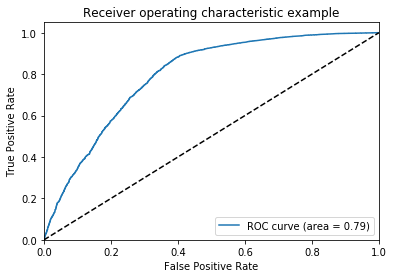

In [29]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
get_ipython().run_line_magic('matplotlib', 'inline')
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
display()